In [1]:
# Ref: https://github.com/jupyter/notebook/issues/1290#issuecomment-204388895
# %env LD_LIBRARY_PATH=$PWD/../../../lib/:$LD_LIBRARY_PATH

## Testing Hopfield model on MNIST dataset

In the [previous tutorial](https://github.com/Nico-Curti/plasticity/blob/main/docs/source/examples/BCM_on_MNIST.ipynb) we have applied the BCM model for memorization of the MNIST patterns.

In the work of [Krotov et al.](https://www.pnas.org/content/116/16/7723), the authors proposed a different implementation of the BCM model, developed to improve the learning efficiency (and convergence speed) of the model.
Their work aims to prove the efficiency of the synergy between biological inspired and standard back-propagation neural network in classification tasks.

Side by side with the paper, the authors provide also a numerical implementation of their model, available on github (ref. [here](https://github.com/DimaKrotov/Biological_Learning))

In `plasticity` library we provide an optimized version of the same algorithm.
The optimizations were performed only on the numerical point-of-view, leaving unaltered the core algorithm.
Our implementation, as much as the BCM one, is fully compatible with the `scikit-learn` library, and integrated into the same framework of the `BCM` model.

Lets try to reproduce the results obtained by Krotov et al. on the MNIST dataset (showed as benchmark in the original paper).

In [2]:
#import pylab as plt
from sklearn.datasets import fetch_openml

# Download the MNIST dataset
X, y = fetch_openml(name='mnist_784', version=1, data_id=None, return_X_y=True)

# normalize the sample into [0, 1]
X *= 1. / 255

print('Data size: {}'.format(X.shape))
print('Label size: {}'.format(y.shape))

Data size: (70000, 784)
Label size: (70000,)


The first step involves always the dataset loading.

Now we can import the Krotov et al. model (renamed as `Hopfield` model) and use it with the same syntax of the `BCM` class.

In [3]:
from plasticity.model import Hopfield

help(Hopfield)

Help on class Hopfield in module plasticity.model.hopfield:

class Hopfield(plasticity.model._base.BasePlasticity)
 |  Hopfield(outputs: int = 100, num_epochs: int = 100, batch_size: int = 100, delta: float = 0.4, optimizer: 'Optimizer' = SGD(lr=0.02, lr_max=inf, lr_min=0.0, decay=0.0), weights_init: 'BaseWeights' = Normal(std=1.0, mu=0.0), p: float = 2.0, k: int = 2, precision: float = 1e-30, epochs_for_convergency: int = None, convergency_atol: float = 0.01, decay: float = 0.0, random_state: int = None, verbose=True)
 |  
 |  Hopfield and Krotov implementation of the BCM algorithm [1]_.
 |  
 |  Parameters
 |  ----------
 |    outputs : int (default=100)
 |      Number of hidden units
 |  
 |    num_epochs : int (default=100)
 |      Maximum number of epochs for model convergency
 |  
 |    batch_size : int (default=10)
 |      Size of the minibatch
 |  
 |    optimizer : Optimizer (default=SGD)
 |      Optimizer object (derived by the base class Optimizer)
 |  
 |    delta : float (

Also in this case the model takes a wide range of possible parameters in input, for the customization of the model performances.

It is interesting to notice that the main difference between the BCM and Hopfield signature is given by the activation function: the Hopfield model does not require any activation function but it just uses the linear one!

Lets start from its usage with all the default parameters

In [4]:
%%time
model = Hopfield(outputs=100, num_epochs=10, batch_size=1000, 
                 verbose=True, random_state=42)
model.fit(X)

  0%|          | 0/70 [00:00<?, ?it/s]

Epoch 1/10


  7%|▋         | 5/70 [00:00<00:01, 47.57it/s]

Epoch 2/10


  7%|▋         | 5/70 [00:00<00:01, 49.78it/s]

Epoch 3/10


  7%|▋         | 5/70 [00:00<00:01, 49.65it/s]

Epoch 4/10


  7%|▋         | 5/70 [00:00<00:01, 49.77it/s]

Epoch 5/10


  7%|▋         | 5/70 [00:00<00:01, 49.63it/s]

Epoch 6/10


  7%|▋         | 5/70 [00:00<00:01, 49.21it/s]

Epoch 7/10


  7%|▋         | 5/70 [00:00<00:01, 49.88it/s]

Epoch 8/10


  7%|▋         | 5/70 [00:00<00:01, 48.67it/s]

Epoch 9/10


  7%|▋         | 5/70 [00:00<00:01, 49.37it/s]

Epoch 10/10


100%|██████████| 70/70 [00:01<00:00, 48.49it/s]

CPU times: user 1min 24s, sys: 1min 53s, total: 3min 17s
Wall time: 14.4 s


Hopfield(convergency_atol=0.01, num_epochs=10, batch_size=1000, outputs=100, optimizer=SGD(lr=0.02, lr_max=inf, lr_min=0.0, decay=0.0), precision=1e-30, weights_init=Normal(std=1.0, mu=0.0), epochs_for_convergency=10, verbose=True, k=2, delta=0.4, decay=0.0, random_state=42, p=2.0)

Also in this case the execution time is quite cheap and confined into the 15s for 10 epochs of training.

As for the BCM model, the most interesting part is given by the inspection of the model weights at the end of the learning procedure.
Using the previously introduced `view_weights` function, we can plot the resulting model synapses and see what the model has learned.

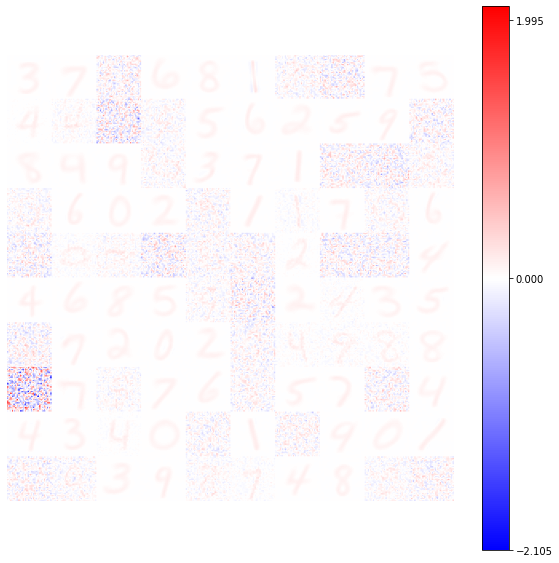

In [5]:
from plasticity.utils import view_weights

view_weights(model.weights, dims=(28, 28))

The result seems to be drastically better than the first result obtained by the BCM model (!), expecially because we have used the model without any alteration of its parameters but just using the default ones (!).

A wide set of neurons show into their weights/synapses a clear shape of MNIST patterns, with positive values for the digit shape and zeros outside (exactly the same pattern of the input images!)

In contrary, there are other neurons which have clearly learned nothing during the trainig and their weights are just white-noise pixels.

This behaviour is determined by the model definition: at each learning epoch, **only** the best neuron is updated, leaving unaltered the others.
Using this learning technique we can guarantee a fast convergence of the neurons *but* we inevitably introduce an hard penalization to the other neurons!

For BCM model we have seen that the initial distribution of the weights can drastically affect the results, obtaining the best result moving from the (default) Normal distribution to the Glorot one.
A second improving factor was given by the Adam optimization algorithm for the parameter updates, in contrary to the (default) Stochastic Gradient Descent.

Lets see if we can improve the learning capacity of the model, altering these two (default) parameters.

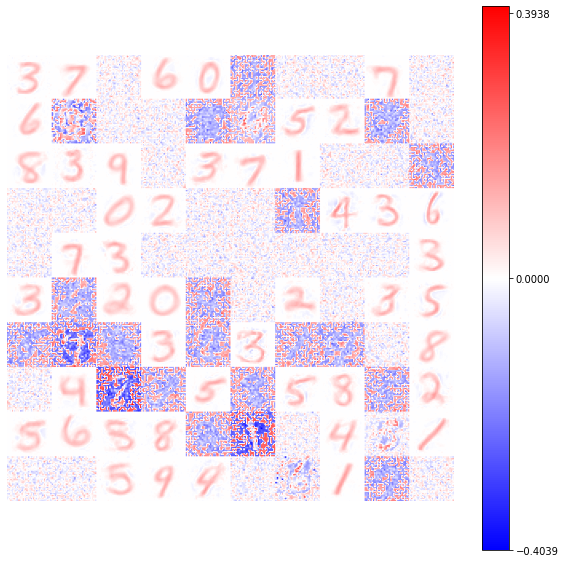

CPU times: user 1min, sys: 1min 22s, total: 2min 23s
Wall time: 15.5 s


In [6]:
%%time
from plasticity.model.optimizer import Adam
from plasticity.model.weights import GlorotNormal

model = Hopfield(outputs=100, num_epochs=10, batch_size=1000, 
                 optimizer=Adam(lr=2e-2),
                 weights_init=GlorotNormal(),
                 verbose=False, random_state=42)
model.fit(X)

view_weights(model.weights, dims=(28, 28))

The result in this case seems to be worse: there are only few neurons which have reached the convergence (and consequently store a MNIST pattern into their parameters), while even more neurons are associated to white-noise.

> ⚠️ **Note:** the colormap used for the visualization can alter your perception of the results! 
> In the above result the stable neurons show a brigher (red) digit in their synapses *but* the range of values in the colorbar has a very narrow range.
> The color perception is affected by the normalization applied for the visualization: the `view_weights` function applies a global normalization, considering all the model neurons.
> The random pattern learned by some neurons (can) determine the maximum value used for the normalization (!)

To determine if this behavior is related to the initial distribution of weights or to the optimization algorithm, lets try to turn off one of them (e.g the Glorot distribution)

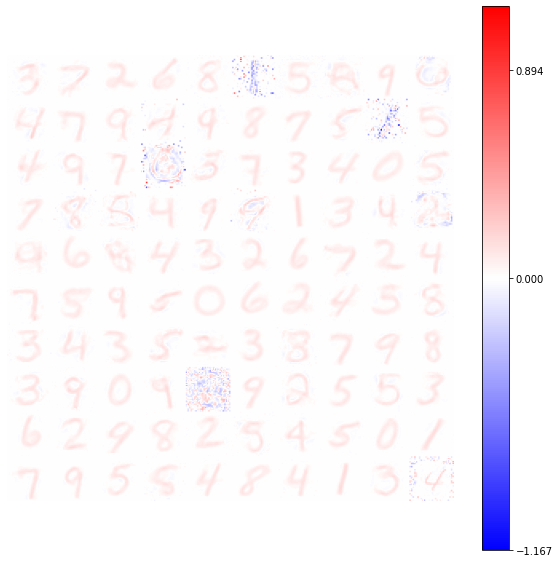

CPU times: user 1min 32s, sys: 1min 56s, total: 3min 28s
Wall time: 14.6 s


In [7]:
%%time

model = Hopfield(outputs=100, num_epochs=10, batch_size=1000, 
                 optimizer=Adam(lr=2e-2),
                 #weights_init=GlorotNormal(),
                 verbose=False, random_state=42)
model.fit(X)

view_weights(model.weights, dims=(28, 28))

Ok now should be clear that for the Hopfield model a shrinked distribution tends to penalize the model convergence, while the introduction of the Adam optimizer helps to enlarge the quantity of neurons which reach a stable state.

There are other parameters which can improve the learning capacity of the models, and other default values to analyze.
We will see in the next tutorials their meaning and effects on the Hopfield model learning.